# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [2]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [3]:
!pip install unidecode

In [4]:
from unidecode import unidecode

In [5]:
data["verse"] = data.apply(lambda x : unidecode(x["verse"]), axis = 1)

In [6]:
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [7]:
data.shape

(3975, 2)

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
data.shape

(3031, 2)

In [10]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [11]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [12]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [13]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [14]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [15]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [16]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.28% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [17]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [18]:
data["seq"] = data.apply(lambda x : text_to_word_sequence(x["verse"]), axis = 1)

In [19]:
data

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,..."
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]"
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

In [20]:
data["lenseq"] = data.apply(lambda x : len(x["seq"]), axis = 1)

/home/eldrad/.pyenv/versions/3.8.6/envs/lewagon3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='lenseq', ylabel='Density'>

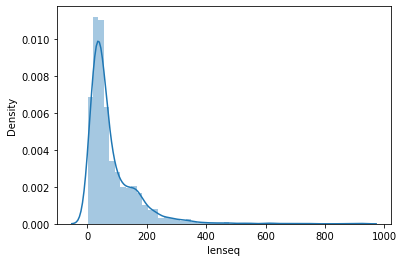

In [21]:
sns.distplot(data.lenseq)

## It seems reasonable to limit sequences to 300 words considering >90% of the sequences are below 300 words

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [22]:
def reduc(ls):
    if len(ls)>300:
        ls = ls[:300]
    return ls

In [23]:
data["seq"] = data.apply(lambda x : reduc(x["seq"]), axis = 1)

In [24]:
data

,artist,verse,seq,lenseq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]",5
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...",60
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...",96
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...",65
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...",61
...,...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,...",18
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl...",110
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]",7
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ...",68


❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [25]:
# data["embed"] = data.apply(lambda x : Word2Vec(x["seq"]), axis = 1)

In [26]:
from gensim.models import Word2Vec
word2vec= Word2Vec(sentences=data.seq, vector_size=100, epochs=50)

/home/eldrad/.pyenv/versions/3.8.6/envs/lewagon3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [27]:
word2vec.wv["love"]

array([-1.2351292 , -2.3670013 , -0.2352285 ,  2.262201  ,  0.7589234 ,
        1.4449484 , -0.43133497, -2.2338328 ,  0.39393097,  0.6393473 ,
        0.3547593 ,  0.56335175, -0.4428864 ,  1.7923586 , -0.2698975 ,
        0.7144872 ,  0.37796608,  3.4217703 ,  0.3581946 ,  0.10821805,
        1.7673181 ,  1.113069  , -0.00676512,  0.9014617 , -1.4569956 ,
        0.04155957,  0.23940764, -0.44669196,  1.605674  ,  0.8333018 ,
       -2.0711873 ,  3.3342798 ,  1.2893767 , -0.8209628 , -1.4414139 ,
       -2.3662074 , -0.46750447,  1.1522377 , -0.54046947,  1.3814152 ,
        0.50163317,  1.8290102 ,  0.5893407 ,  1.3562895 , -0.06766365,
        1.4170996 ,  0.9810065 , -1.0787134 ,  1.3125812 ,  0.67546046,
        1.3274386 ,  1.0265759 ,  0.68808675, -0.38124666, -2.0271094 ,
       -2.9030895 ,  0.45477414,  2.3218424 , -0.07229476, -1.9012712 ,
       -2.562793  ,  0.7098269 ,  0.0819611 , -0.7126021 ,  0.6524371 ,
       -0.60358983, -1.5708071 ,  1.422629  ,  0.65858525,  0.22

In [41]:
def vectorize(ls):
    vec = []
    for word in ls:
        try:
            vec.append(word2vec.wv[word])
        except KeyError:
            pass
    return vec

In [42]:
data["embed"] = data.apply(lambda x : vectorize(x["seq"]), axis = 1)

In [43]:
data

,artist,verse,seq,lenseq,embed
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]",5,"[[0.09851019, 0.11722211, 0.5403208, 0.4121847..."
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...",60,"[[-0.039697714, -1.1184418, -1.9613959, 0.9153..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...",96,"[[0.53566396, 0.99618757, -0.5785804, 0.612891..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...",65,"[[-0.5079117, -1.719914, -0.416506, 0.7707889,..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...",61,"[[-0.039697714, -1.1184418, -1.9613959, 0.9153..."
...,...,...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,...",18,"[[0.3901342, 1.3878834, 0.35831797, 0.8644998,..."
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl...",110,"[[-0.6498834, 0.865852, -1.243647, 0.08528367,..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]",7,"[[0.53566396, 0.99618757, -0.5785804, 0.612891..."
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ...",68,"[[-0.911621, 1.7234297, -0.7249461, -0.5387513..."


In [44]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [49]:
X = np.empty((3031,300,100))

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [53]:
y = np.empty((3031,3))

👉 We train/test split the dataset below for you

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

In [57]:
!curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle > data_lyrics_solution.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  693M  100  693M    0     0  5399k      0  0:02:11  0:02:11 --:--:-- 4864k    0  0:02:14  0:01:21  0:00:53 6739k


❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [65]:
score_baseline = 0

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [66]:
def initialize_model():
    
    model = Sequential()
    
    model.add(layers.LSTM(units = 20, activation = "tanh"))
    
    model.add(layers.Dense(10, activation = "relu"))
    
    model.add(layers.Dense(1, activation = "sigmoid"))
    
    model.compile(loss = "multivariate_crossentropy", metrics = "accuracy", optimizer = "RMSprop")
    
    return model

model = initialize_model()

NameError: name 'Sequential' is not defined

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [ ]:
# YOUR CODE HERE

❓ **Plot the training and validation losses through training**

In [ ]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [ ]:
# YOUR CODE HERE

🧪 **Send your results below**

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()